In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader,TensorDataset,Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
class Fset(Dataset):
    def __init__(self, X,f):
        self.data_x = X
        self.func = f
        self.data_y=np.array([[self.func(x) for x in X]]).T

    def __len__(self):
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        y=self.data_y[idx]
        x=self.data_x[idx]
  
        return y,x

In [4]:
def f(x):
    x=torch.tensor(x)
    y=torch.sin(x)/x-x/10
    return  y

In [5]:
X=np.linspace(0.1,10,1000)

In [6]:
data=Fset(X,f)
batch_size=32

In [7]:
real_data= DataLoader(data,batch_size=batch_size, shuffle=True)

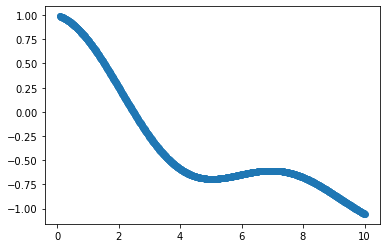

In [9]:
Y=np.array([[f(x) for x in X]]).T
plt.scatter(X, Y)

In [10]:
Y.shape

(1000, 1)

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Звездочка означает unpacking списка
#             *block(128, 256, activation='lrelu'),
#             *block(256, 512),
#             *block(512, 1024),
            nn.Linear(128, int(np.prod(*Y[0].shape))),
            nn.Tanh()
        )
        # 2

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0),*Y[0].shape)
#         print(444,img.size())
        return img


In [21]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса кка параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные на трнспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(Y[0].shape[0], 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
#         print(333,validity.size())

        return validity

In [23]:
n_epochs = 200 # количество эпох
lr = 0.0002 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

latent_dim = 100 # Размерность случайного вектора, который подается на вход генератору

epoch_interval = 50
sample_interval = 29 # количество картинок для отображения процесса обучения

In [24]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [25]:
d_loss_history = []
g_loss_history = []

28 49
32 32


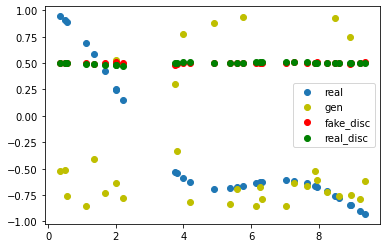

[Epoch 49/200] [Batch 28/32] [D loss: 0.693847] [G loss: 0.693393][F loss: 0.693016]
28 99
32 32


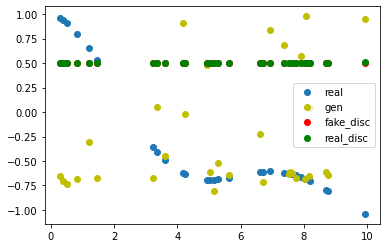

[Epoch 99/200] [Batch 28/32] [D loss: 0.693143] [G loss: 0.693362][F loss: 0.692940]
28 149
32 32


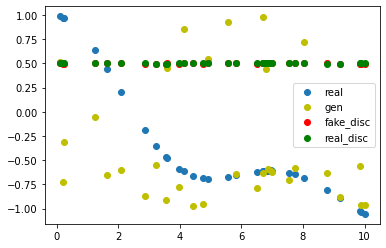

[Epoch 149/200] [Batch 28/32] [D loss: 0.692713] [G loss: 0.693399][F loss: 0.692923]
28 199
32 32


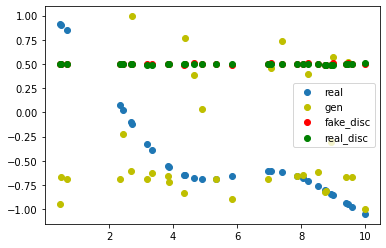

[Epoch 199/200] [Batch 28/32] [D loss: 0.694267] [G loss: 0.695628][F loss: 0.690728]


In [17]:
import matplotlib.patches as mpatches


for epoch in range(n_epochs):
    for i, (y,x) in enumerate(real_data):
        
        
        
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_imgs = y.type(torch.FloatTensor).to(device)
        
#         print(777,real_imgs.size())


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
#         print(.shape)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
#         print('d0')
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
#         print(g_loss)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
#         print('d1')
#         print(real_pred.size(),valid.size())
        if real_pred.size()==valid.size():
            

            # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
            d_real_loss = adversarial_loss(real_pred, valid)

            # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
            fake_pred = discriminator(gen_imgs.detach())
#             print('d2')

            # расчитываем ошибку предсказанного с фейковыми лейблами
            d_fake_loss = adversarial_loss(fake_pred, fake)

            # И усредняем два лосса в один
            d_loss = (d_real_loss + d_fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
#         batches_done = epoch * len(real_data) + i
    
#         if epoch % epoch_interval == 0:
#         print(i,epoch)
        if ((i+1) % sample_interval == 0 and (epoch+1) % 50 == 0):
            print(i,epoch)
            
            with torch.no_grad():
#                 plt.clf()
                plt.scatter(x,y.flatten(), label='real')
                plt.scatter(x,gen_imgs.detach().cpu().numpy().flatten(), c='y', label='gen')
                plt.scatter(x,fake_pred.detach().cpu().numpy().flatten(), c='r', label='fake_disc')
                print(len(x),len(real_pred.detach().cpu().numpy().flatten()))
                plt.scatter(x,real_pred.detach().cpu().numpy().flatten(), c='g', label='real_disc')
                plt.legend()
                plt.show()

# #                 display.clear_output(wait=False)
# #                 sample_image(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f][F loss: %f]"% 
                      (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item(),d_fake_loss.item()) ) 


# #                 display.display(plt.gcf())

#                 d_loss = d_loss.cpu().detach()
#                 g_loss = g_loss.cpu().detach()
                
                


#                 d_loss_history.append(d_loss)
#                 g_loss_history.append(g_loss)

#                 plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
#                 plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
#                 plt.legend(handles=[red_patch, green_patch])
#                 plt.show()

            